In [2]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 174 GB / percent used: 30.7 %


In [3]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Variable
var = 'ta'
table = u.get_table(var)
    
var_label = 'Air Temperature [°C]'
var_label_trends = 'Air Temperature trends [°C/dec]'
var_label_bias = 'Air Temperature bias [°C]'
cmap='CoolWarm'
levels=plot.arange(-30,30,5)

# Load obs
## ERA-Interim

See: http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/ta-global.ipynb

In [4]:
obs_longname = 'ERA-Interim'
obs_name = 'ERA-Interim'

obs_clim = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).ta.sel(time=period).mean('time').load()-273.15

ps_obs_min = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",combine='by_coords', parallel=True
).sp.sel(time=period).min('time').load()

# Load model data
Get only models with tas, ta, ps, snc, for comparisons (http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/ta-global_multimodel/list_models.ipynb)

For masking see an example: http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/ta-global_multimodel/ta-global_AWI-CM-1-1-MR.ipynb  
I am trying to compute the climatologies first, otherwise it is too havy...


## Make computation and save results

In [5]:
from os import path

list_models = [
#     'BCC-CSM2-MR', 
#     'BCC-ESM1', 
#     'CESM2', 
#     'CESM2-FV2', 
#     'CESM2-WACCM', 
#     'CESM2-WACCM-FV2', 
#     'CanESM5', 
#     'EC-Earth3-Veg', 
#     'FGOALS-f3-L', 
#     'GFDL-CM4', 
#     'GISS-E2-1-G', 
#     'GISS-E2-1-G-CC', 
#     'GISS-E2-1-H', 
#     'IPSL-CM6A-LR', 
#     'MIROC6', 
#     'MPI-ESM1-2-HR', 
#     'MPI-ESM1-2-LR', 
#     'MRI-ESM2-0', 
    'NorCPM1', 
#     'NorESM2-LM', 
#     'SAM0-UNICON'
]

realization = 'r1i1p1f1'

bias_global = []
clim_global = []

bias_HMA = []
clim_HMA = []

bias_global_without_HMA = []
clim_global_without_HMA = []

for model in list_models:
    print(model)
    institute, grid = u.select_model(model, var)

    model_clim = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', combine='by_coords'
    ).sel(time=period)[var].mean('time')-273.15

    # Load min surface pressure to mask values under the surface
    ps_model_min = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/ps/'+grid+'/latest/*.nc', 
        combine='by_coords'
    ).sel(time=period)['ps'].min('time')

    # Regrid towards model
    regridder = xe.Regridder(obs_clim, model_clim, 'bilinear', periodic=True, reuse_weights=True)
    obs_clim_regrid = regridder(obs_clim)
    ps_obs_min_regrid = regridder(ps_obs_min)

    # Mask vertical values > ps
    obs_clim_regrid_masked = obs_clim_regrid.where(obs_clim_regrid.level <= ps_obs_min_regrid/100)
    model_clim_masked = model_clim.where(model_clim.plev <= ps_model_min)

    # Regrid vertical
    obs_clim_regrid_masked_v = obs_clim_regrid_masked.interp(level=(model_clim.plev.values/100), method='linear')

    # Store results
    bias_global.append( (model_clim_masked - obs_clim_regrid_masked_v.values).mean('lon', skipna=False).persist() )
    clim_global.append( model_clim_masked.mean('lon', skipna=False).persist() )

    bias_HMA.append( (model_clim_masked - obs_clim_regrid_masked_v.values).sel(lon=slice(lonlim[0],lonlim[1])).mean('lon', skipna=False).persist() )
    clim_HMA.append( model_clim_masked.sel(lon=slice(lonlim[0],lonlim[1])).mean('lon', skipna=False).persist() )

    bias_global_without_HMA.append( (model_clim_masked - obs_clim_regrid_masked_v.values).where((model_clim_masked.lon < lonlim[0]) | (model_clim_masked.lon > lonlim[1]), drop=True).mean('lon', skipna=False).persist() )
    clim_global_without_HMA.append( model_clim_masked.where((model_clim_masked.lon < lonlim[0]) | (model_clim_masked.lon > lonlim[1]), drop=True).mean('lon', skipna=False).persist() )

NorCPM1
Reuse existing file: bilinear_241x480_142x144_peri.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: Al

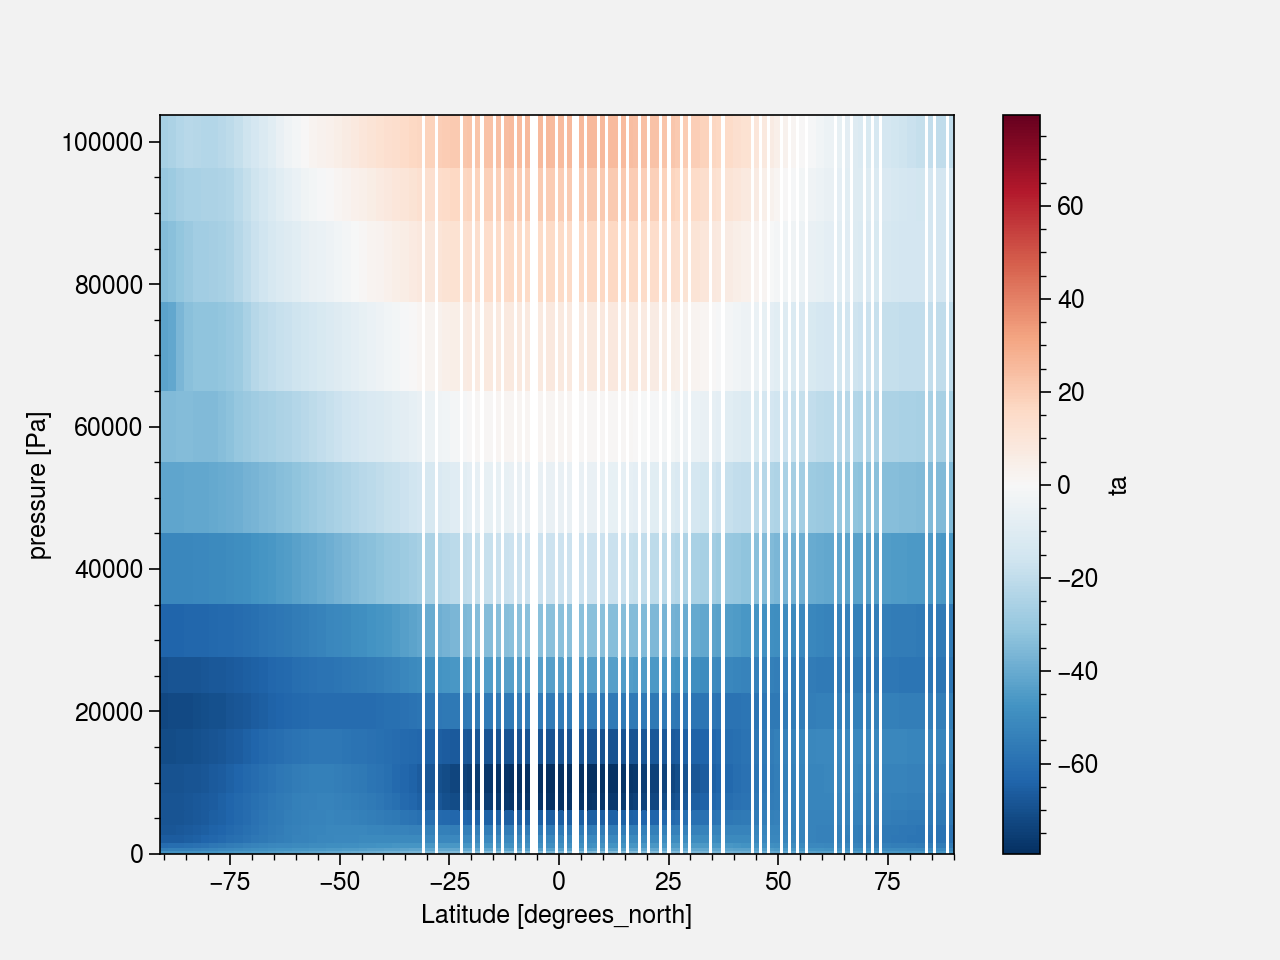

In [9]:
model_clim.mean('lon').plot()

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


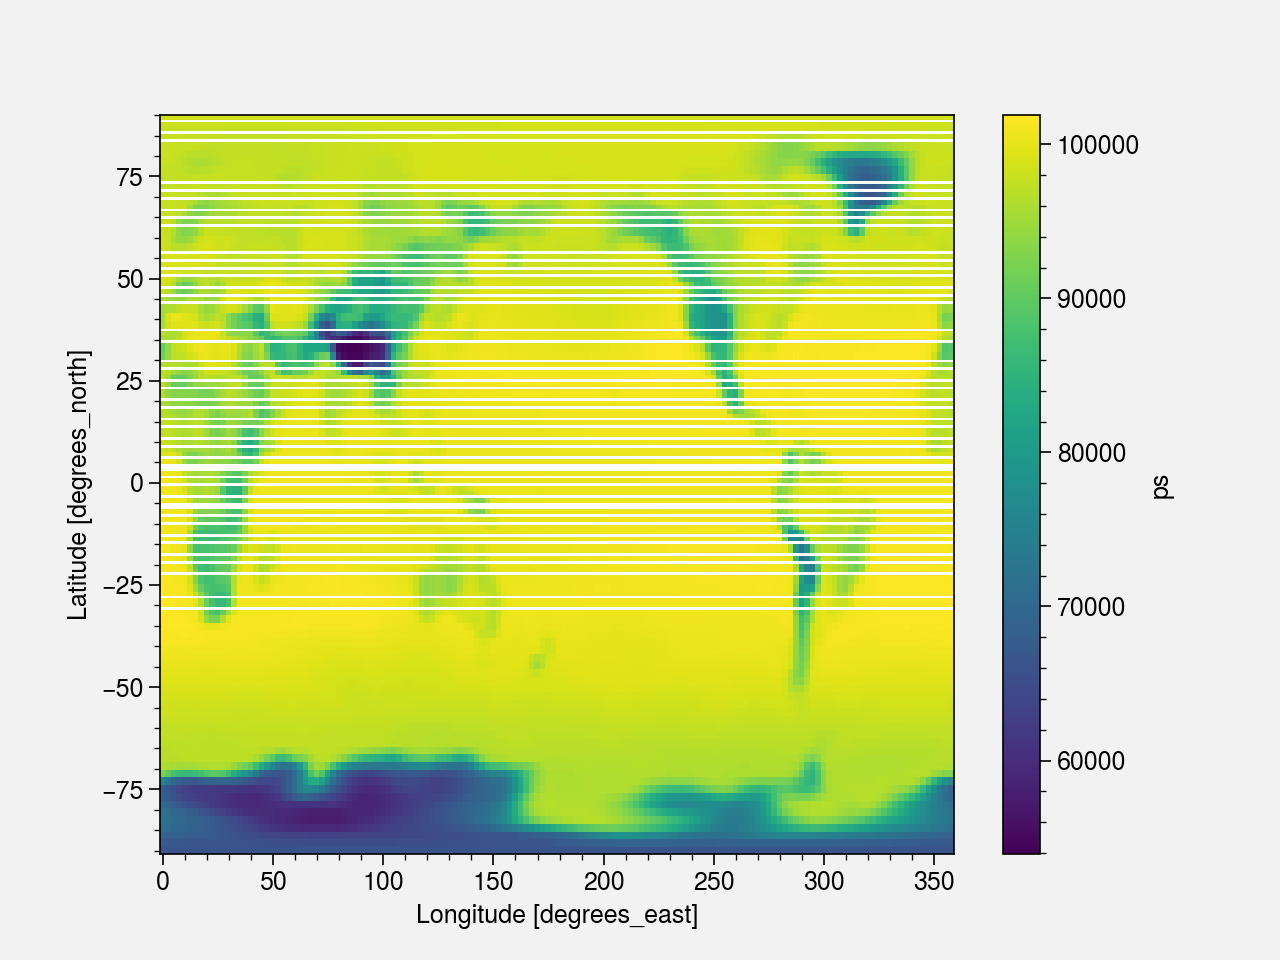

In [11]:
ps_model_min.plot()

## Plot results

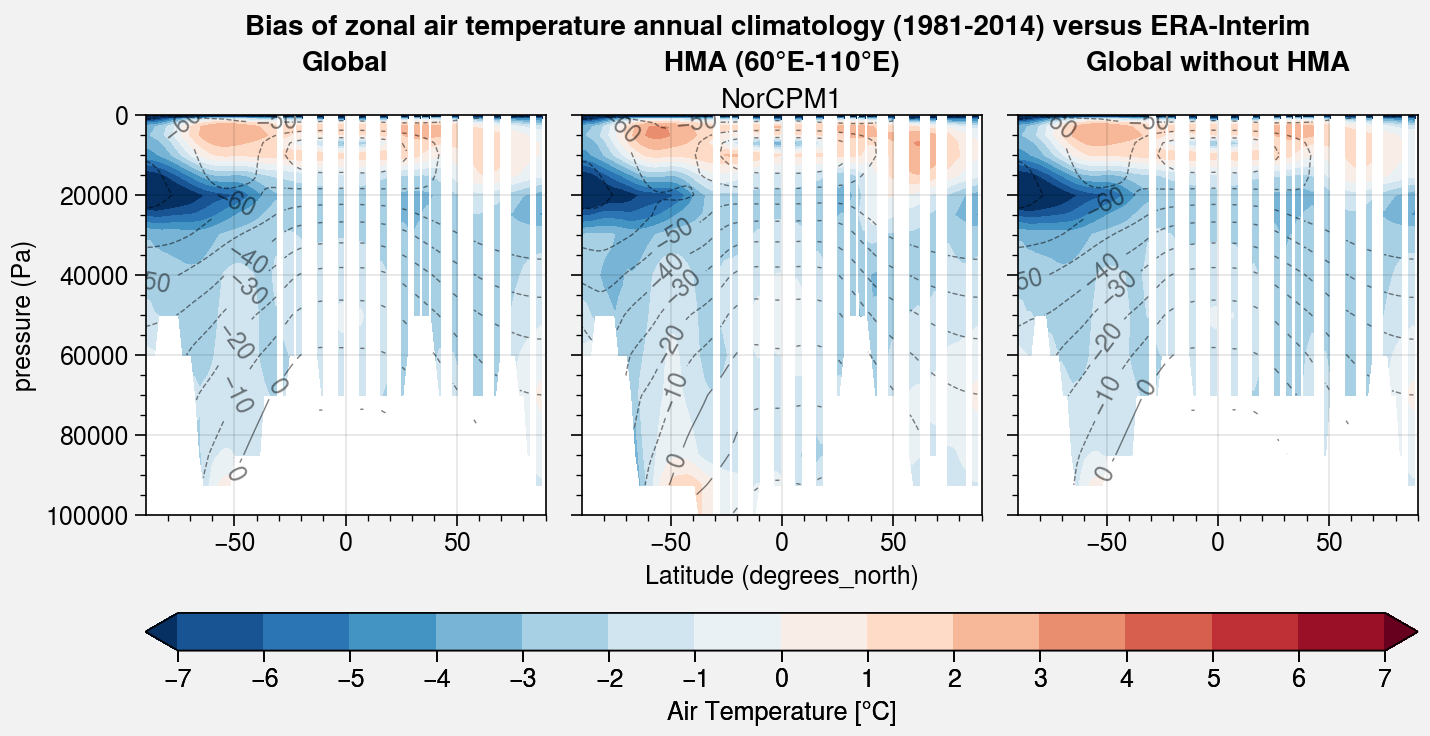

In [6]:
levels=plot.arange(-7,7,1)
extend='both'
cmap='BuRd'
ncols=3
lw=0.5
alpha=0.5
ylim=(100000,0)

f, axs = plot.subplots(ncols=ncols, nrows=1, axwidth=2)

k=0
for i in range(0,1):
    # Model
    axs[k].contourf(bias_global[i], cmap=cmap, levels=levels, extend=extend)
    axs[k].contour(clim_global[i], color='black', labels=True, lw=lw, alpha=alpha)
    axs[k].format(ylim=ylim, title='')
    k += 1

    # ERA-Interim
    axs[k].contourf(bias_HMA[i], cmap=cmap, levels=levels, extend=extend)
    axs[k].contour(clim_HMA[i], color='black', labels=True, lw=lw, alpha=alpha)
    axs[k].format(ylim=ylim, title=list_models[i])
    k += 1

    # Bias
    m = axs[k].contourf(bias_global_without_HMA[i], cmap=cmap, levels=levels, extend=extend)
    axs[k].contour(clim_global_without_HMA[i], color='black', labels=True, lw=lw, alpha=alpha)
    axs[k].format(ylim=ylim, title='')
    k += 1
    
    
f.colorbar(m, label=var_label, loc='b')   


axs.format(
    suptitle="Bias of zonal air temperature annual climatology (1981-2014) versus ERA-Interim ",
    collabels=['Global', 'HMA (60°E-110°E)', 'Global without HMA'],
#     rowlabels=list_models
)